In [1]:
import torch
import os
import matplotlib.pyplot as plt
os.chdir("..")


from epilearn.models.Temporal.LSTM import LSTMModel
from epilearn.models.Temporal.GRU import GRUModel
from epilearn.models.Temporal.Dlinear import DlinearModel
from epilearn.models.Temporal.XGB import XGBModel
from epilearn.models.Temporal.ARIMA import VARMAXModel

from epilearn.data import UniversalDataset
from epilearn.utils import utils

# initial settings
device = torch.device('cpu')
torch.manual_seed(7)

lookback = 12 # inputs size
horizon = 3 # predicts size


permute = False

epochs = 50 # training epochs
batch_size = 50 # training batch size

In [3]:
dataset = UniversalDataset()
dataset.load_toy_dataset()


# load toy dataset
dataset = UniversalDataset()
dataset.load_toy_dataset()

device = torch.device('cpu')
# preprocessing
features, mean, std = utils.normalize(dataset.x)
# adj_norm = utils.normalize_adj(dataset.graph)

features = features.to(device)
# adj_norm = adj_norm.to(device)

# prepare datasets
train_rate = 0.6 
val_rate = 0.2

split_line1 = int(features.shape[0] * train_rate)
split_line2 = int(features.shape[0] * (train_rate + val_rate))

train_original_data = features[:split_line1, :, :]
val_original_data = features[split_line1:split_line2, :, :]
test_original_data = features[split_line2:, :, :]

train_input, train_target = dataset.generate_dataset(X = train_original_data, Y = train_original_data[:, :, 0], lookback_window_size = lookback, horizon_size = horizon, permute = permute)
val_input, val_target = dataset.generate_dataset(X = val_original_data, Y = val_original_data[:, :, 0], lookback_window_size = lookback, horizon_size = horizon, permute = permute)
test_input, test_target = dataset.generate_dataset(X = test_original_data, Y = test_original_data[:, :, 0], lookback_window_size = lookback, horizon_size = horizon, permute = permute)

# Selecting the first region for both input and target
train_input = train_input[:, :, 0, :]  # Selecting the first region across all timesteps and features
train_target = train_target[:, :, 0]  # Selecting the first region for the target

val_input = val_input[:, :, 0, :]
val_target = val_target[:, :, 0]

test_input = test_input[:, :, 0, :]
test_target = test_target[:, :, 0]

# shape of train_input: (num_samples, num_timesteps, num_features)

# prepare model

# model = GRUModel(
#             num_features=train_input.shape[2],
#             num_timesteps_input=lookback,
#             num_timesteps_output=horizon
#             ).to(device=device)

# model = XGBModel(num_features=train_input.shape[2],
#             num_timesteps_input=lookback,
#             num_timesteps_output=horizon)

model = VARMAXModel(num_features=train_input.shape[2],
            num_timesteps_input=lookback,
            num_timesteps_output=horizon)

# model = LSTMModel(
#             num_features = train_input.shape[2],
#             num_timesteps_input = lookback,
#             num_timesteps_output = horizon
#             ).to(device = device)


# model = DlinearModel(
#             num_features=train_input.shape[2],
#             num_timesteps_input=lookback,
#             num_timesteps_output=horizon
#             ).to(device=device)





In [4]:
# training
model.fit(
        train_input = train_input, 
        train_target = train_target, 
        # graph = adj_norm, 
        val_input = val_input, 
        val_target = val_target, 
        verbose = True,
        batch_size = batch_size,
        epochs = epochs)

/Users/liyunxiao/anaconda3/envs/dream/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/liyunxiao/anaconda3/envs/dream/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/liyunxiao/anaconda3/envs/dream/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/liyunxiao/anaconda3/envs/dream/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Use

MSE Loss: 0.09773994001111155


/Users/liyunxiao/anaconda3/envs/dream/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[array([-0.89873832, -0.5371265 , -0.11287244]),
 array([-0.5324799 , -0.0825422 ,  0.18990693]),
 array([-0.21796303, -0.6851609 , -0.73115542]),
 array([-0.16852574, -0.53741122, -0.77472364]),
 array([-0.25617409, -0.46976363, -0.5087139 ]),
 array([-0.27535635, -0.32783448, -0.29080593]),
 array([-0.41540173, -0.26586429, -0.13438964]),
 array([-0.5743639 , -0.61710933, -0.45884514]),
 array([-0.27473588, -0.04867889, -0.25972552]),
 array([-0.3069251 , -0.19528572, -0.3245269 ])]

In [5]:

def get_MAE(pred, target):
    return torch.mean(torch.absolute(pred - target))

# evaluate
out = model.predict(feature = test_input)
preds = out.detach().cpu() * std[0] + mean[0]
targets = test_target.detach().cpu() * std[0] + mean[0]
# MAE
mae = get_MAE(preds, targets)
print(f"MAE: {mae.item()}")



/Users/liyunxiao/anaconda3/envs/dream/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/liyunxiao/anaconda3/envs/dream/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/liyunxiao/anaconda3/envs/dream/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/liyunxiao/anaconda3/envs/dream/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Use

MAE: 136.98390974718257


/Users/liyunxiao/Desktop/temporal/Dreamy/dreamy/models/Temporal/ARIMA.py:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403251597/work/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(all_forecasts)


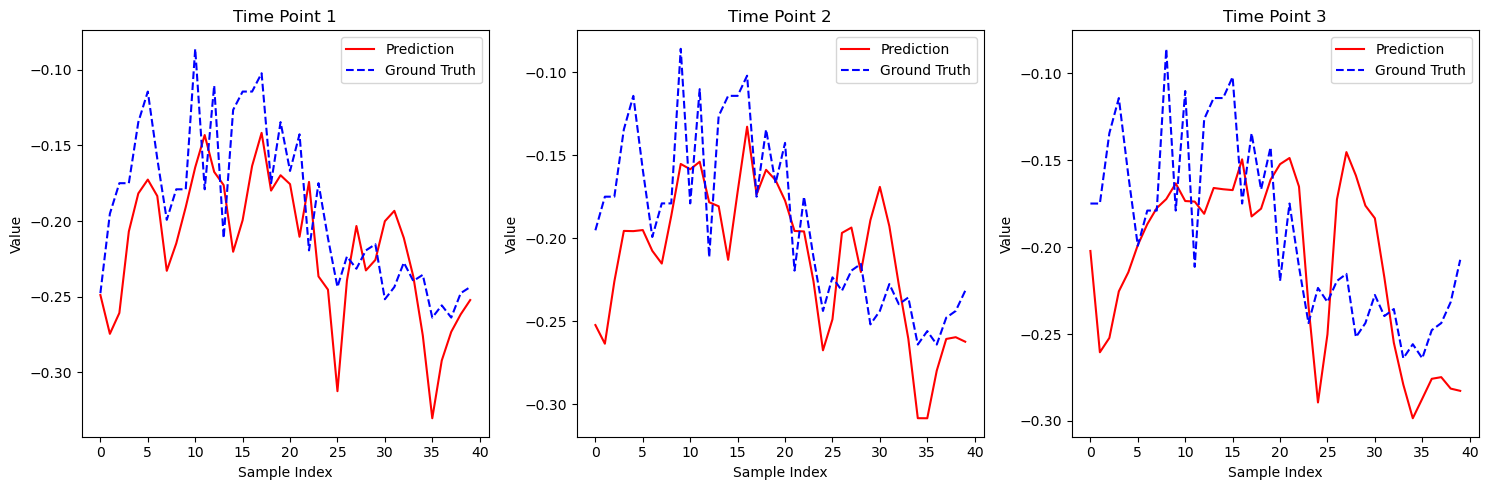

In [5]:
import matplotlib.pyplot as plt
import torch


out = model.predict(feature=train_input).detach().cpu()

num_samples = 40  # Number of samples to display
time_points = 3  # Each sample predicts the next 3 time points

plt.figure(figsize=(15, 5))
for t in range(time_points):
    plt.subplot(1, 3, t + 1)
    
    # Gather all predictions and actual values for the t-th future time point across the first 40 samples
    predictions = out[:num_samples, t]
    truths = train_target[:num_samples, t]

    # Plotting the predictions and ground truth values
    plt.plot(range(num_samples), predictions.numpy(), 'r-', label='Prediction')
    plt.plot(range(num_samples), truths.numpy(), 'b--', label='Ground Truth')
    plt.title(f"Time Point {t + 1}")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.show()


